Calculando solución por diferencias finitas...

Entrenando modelo Lagaris...
Epoch 0: Loss = 0.8164
Epoch 500: Loss = 0.0005
Epoch 1000: Loss = 0.0001
Epoch 1500: Loss = 0.0000

Entrenando modelo PINN...
Epoch 0: Loss = 0.2899
Epoch 500: Loss = 0.0003
Epoch 1000: Loss = 0.0001
Epoch 1500: Loss = 0.0000


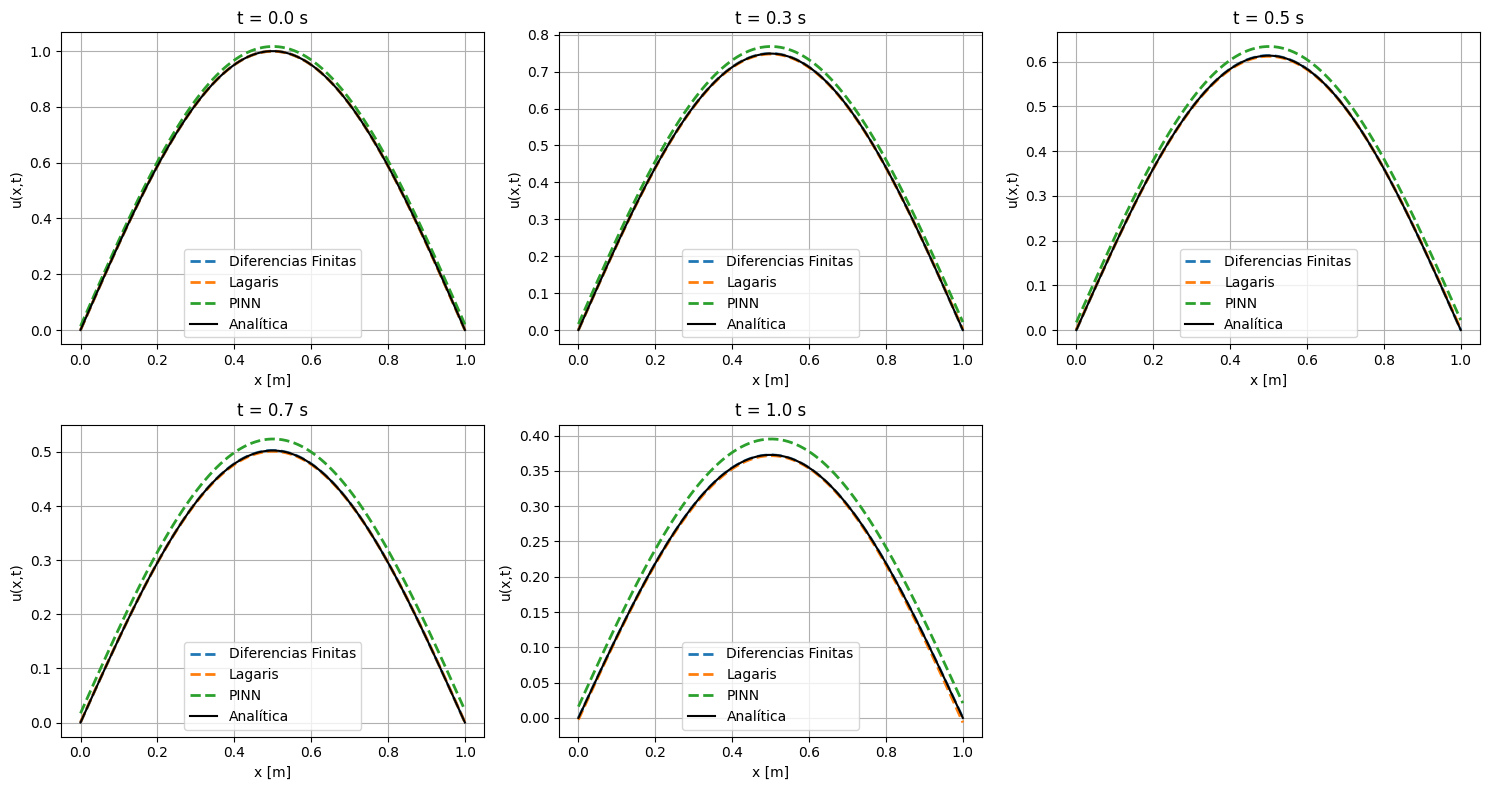


Tabla Comparativa de Errores:
                Método       MAE      RMSE
0  Diferencias Finitas  7.16e-05  1.03e-04
1              Lagaris  8.54e-04  1.05e-03
2                 PINN  1.99e-02  2.00e-02


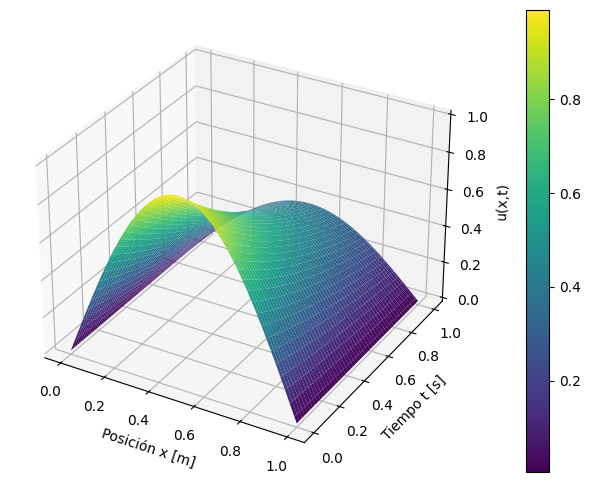

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from mpl_toolkits.mplot3d import Axes3D
from pandas import DataFrame

# Configuración para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

# ==============================================================================
# Configuración común
# ==============================================================================
alpha = 0.1       # Coeficiente de difusión [m²/s]
L = 1.0           # Longitud del dominio [m]
T_max = 1.0       # Tiempo máximo de simulación [s]

# Grilla de evaluación (100x100) para la solución analítica y NN
x_eval = torch.linspace(0, L, 100)
t_eval = torch.linspace(0, T_max, 100)
X_eval, T_eval = torch.meshgrid(x_eval, t_eval, indexing='ij')

def analytical_solution(x, t):
    return torch.sin(np.pi * x / L) * torch.exp(-alpha * (np.pi / L)**2 * t)

U_true = analytical_solution(X_eval, T_eval).detach().numpy()

# ==============================================================================
# 1. Método: Diferencias Finitas Explícitas
# ==============================================================================
def finite_difference_solution():
    # Usamos la misma grilla espacial de evaluación (100 puntos)
    x_fd = torch.linspace(0, L, 100)
    dx = x_fd[1] - x_fd[0]
    # Para estabilidad explícita: dt <= 0.5*dx^2/alpha
    dt = 0.0005  # escogido menor o igual a 0.5*dx^2/alpha
    max_dt = 0.5 * dx**2 / alpha
    assert dt <= max_dt, f"dt muy grande: dt={dt}, max_dt={max_dt}"

    # Número de pasos temporales
    n_t = int(T_max / dt) + 1
    t_fd = torch.linspace(0, T_max, n_t)

    U = torch.zeros((len(x_fd), n_t))
    # Condición inicial: u(x,0) = sin(πx/L)
    U[:, 0] = torch.sin(np.pi * x_fd / L)
    # Condiciones de frontera: u(0,t)=u(L,t)=0
    U[0, :] = 0.0
    U[-1, :] = 0.0

    Fo = alpha * dt / dx**2

    for n in range(n_t - 1):
        U[1:-1, n+1] = U[1:-1, n] + Fo * (U[2:, n] - 2*U[1:-1, n] + U[:-2, n])

    # Se samplea la solución en 100 tiempos uniformemente distribuidos (igual que t_eval)
    indices = np.linspace(0, n_t - 1, 100, dtype=int)
    U_sampled = U[:, indices]
    return U_sampled.detach().numpy()

# ==============================================================================
# 2. Método Lagaris (Neural Network con penalización de condiciones)
# ==============================================================================
class LagarisNN(nn.Module):
    def __init__(self):
        super(LagarisNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x, t):
        inp = torch.cat([x.unsqueeze(1), t.unsqueeze(1)], dim=1)
        return self.net(inp).squeeze()

def train_lagaris():
    model = LagarisNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    # Generamos puntos en la grilla de evaluación (100x100)
    x = torch.linspace(0, L, 100)
    t = torch.linspace(0, T_max, 100)
    X, T = torch.meshgrid(x, t, indexing='ij')
    inputs = torch.stack([X.reshape(-1), T.reshape(-1)], dim=1)

    # Máscaras para la condición inicial y de frontera
    initial_mask = (T.reshape(-1) == 0)
    boundary_mask = ((X.reshape(-1) == 0) | (X.reshape(-1) == L))

    for epoch in range(2000):
        optimizer.zero_grad()
        u_pred = model(inputs[:, 0], inputs[:, 1])

        loss_ic = torch.mean((u_pred[initial_mask] - torch.sin(np.pi * inputs[initial_mask, 0] / L))**2)
        loss_bc = torch.mean(u_pred[boundary_mask]**2)

        # Se reorganiza la predicción en forma de grilla (100x100)
        u_grid = u_pred.reshape(100, 100)
        # Aproximación de la derivada temporal: diferencia finita en t
        dt_eval = T_max / (100 - 1)
        u_t = (u_grid[:, 1:] - u_grid[:, :-1]) / dt_eval  # forma: (100, 99)
        # Aproximación de la segunda derivada espacial: diferencia central
        dx_eval = L / (100 - 1)
        u_xx = (u_grid[2:, :] - 2*u_grid[1:-1, :] + u_grid[:-2, :]) / dx_eval**2  # forma: (98, 100)
        # Se toma el área de intersección para tener formas compatibles:
        # u_t[1:-1, :] tiene forma (98, 99) y u_xx[:, :-1] también (98, 99)
        loss_pde = torch.mean((u_t[1:-1, :] - alpha * u_xx[:, :-1])**2)

        total_loss = loss_ic + loss_bc + loss_pde
        total_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {total_loss.item():.4f}")

    return model

# ==============================================================================
# 3. PINNs (Physics-Informed Neural Networks)
# ==============================================================================
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, t):
        inp = torch.cat([x.unsqueeze(1), t.unsqueeze(1)], dim=1)
        return self.net(inp).squeeze()

def train_pinn():
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Puntos de colocation para la PDE (distribuidos aleatoriamente)
    N = 1000
    X_pde = torch.rand(N, 2)
    X_pde[:, 0] = X_pde[:, 0] * L
    X_pde[:, 1] = X_pde[:, 1] * T_max

    # Puntos para condición inicial (t=0)
    X_ic = torch.cat([torch.rand(200, 1) * L, torch.zeros(200, 1)], dim=1)

    # Puntos para condición de frontera (x=0 y x=L)
    X_bc_left = torch.cat([torch.zeros(100, 1), torch.rand(100, 1) * T_max], dim=1)
    X_bc_right = torch.cat([torch.ones(100, 1) * L, torch.rand(100, 1) * T_max], dim=1)
    X_bc = torch.cat([X_bc_left, X_bc_right], dim=0)

    for epoch in range(2000):
        optimizer.zero_grad()

        # Pérdida de la PDE
        X_pde.requires_grad_(True)
        u = model(X_pde[:, 0], X_pde[:, 1])
        grad_u = torch.autograd.grad(u, X_pde, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        du_dt = grad_u[:, 1]
        du_dx = grad_u[:, 0]
        d2u_dx2 = torch.autograd.grad(du_dx.sum(), X_pde, create_graph=True)[0][:, 0]
        loss_pde = torch.mean((du_dt - alpha * d2u_dx2)**2)

        # Pérdida de condición inicial
        u_ic = model(X_ic[:, 0], X_ic[:, 1])
        loss_ic = torch.mean((u_ic - torch.sin(np.pi * X_ic[:, 0] / L))**2)

        # Pérdida de condición de frontera
        u_bc = model(X_bc[:, 0], X_bc[:, 1])
        loss_bc = torch.mean(u_bc**2)

        loss = loss_pde + loss_ic + loss_bc
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    return model

# ==============================================================================
# Visualización y Comparación
# ==============================================================================
def plot_comparison(models):
    plt.figure(figsize=(15, 8))
    times = [0.0, 0.3, 0.5, 0.7, 1.0]

    for i, t_val in enumerate(times):
        plt.subplot(2, 3, i+1)
        # Se obtiene el índice correspondiente en la grilla de evaluación (100 puntos)
        idx = int(t_val / T_max * (100 - 1))
        for name, U in models.items():
            plt.plot(x_eval.numpy(), U[:, idx], '--', linewidth=2, label=name)
        plt.plot(x_eval.numpy(), U_true[:, idx], 'k-', label='Analítica')
        plt.title(f"t = {t_val:.1f} s")
        plt.xlabel('x [m]')
        plt.ylabel('u(x,t)')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Tabla comparativa de errores
    error_data = []
    for name, U in models.items():
        mae = np.mean(np.abs(U - U_true))
        rmse = np.sqrt(np.mean((U - U_true)**2))
        error_data.append([name, f"{mae:.2e}", f"{rmse:.2e}"])

    print("\nTabla Comparativa de Errores:")
    print(DataFrame(error_data, columns=["Método", "MAE", "RMSE"]))

    # Gráfico 3D (usando la solución de diferencias finitas)
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(111, projection='3d')
    X, T = np.meshgrid(x_eval.numpy(), t_eval.numpy())
    surf = ax.plot_surface(X, T, models["Diferencias Finitas"].T, cmap='viridis', rstride=2, cstride=2)
    ax.set_xlabel('Posición x [m]')
    ax.set_ylabel('Tiempo t [s]')
    ax.set_zlabel('u(x,t)')
    fig.colorbar(surf)
    plt.show()

# ==============================================================================
# Bloque principal
# ==============================================================================
if __name__ == "__main__":
    print("="*60)
    print("Calculando solución por diferencias finitas...")
    fd_U = finite_difference_solution()

    print("\n" + "="*60)
    print("Entrenando modelo Lagaris...")
    lagaris_model = train_lagaris()
    with torch.no_grad():
        inputs = torch.stack([X_eval.reshape(-1), T_eval.reshape(-1)], dim=1)
        lagaris_U = lagaris_model(inputs[:, 0], inputs[:, 1]).reshape(100, 100).detach().numpy()

    print("\n" + "="*60)
    print("Entrenando modelo PINN...")
    pinn_model = train_pinn()
    with torch.no_grad():
        inputs = torch.stack([X_eval.reshape(-1), T_eval.reshape(-1)], dim=1)
        pinn_U = pinn_model(inputs[:, 0], inputs[:, 1]).reshape(100, 100).detach().numpy()

    # Se almacenan las soluciones de cada método en un diccionario para comparar
    models = {
        "Diferencias Finitas": fd_U,
        "Lagaris": lagaris_U,
        "PINN": pinn_U
    }

    plot_comparison(models)
